## Scraping

### Pushshift Imports

In [343]:
import requests
import pandas as pd
import time
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
import regex as re

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.ensemble import RandomForestClassifier

from nltk.sentiment.vader import SentimentIntensityAnalyzer

### Defining a Function to Scrape Reddit

The function uses pushshift.io API and scrapes the metadata of the 10,000 most recent post from now for the specified subreddit

In [5]:
#fetches 10,000 submissions starting NOW, going backwards

def fetch_data(subreddit, size, samples, after = None, before = round(time.time())):
    
    newest_timestamp =[]
    all_posts = []
    
       
    for x in range(samples):
        base_url = 'https://api.pushshift.io/reddit/submission/search'
        
        params = {
        "subreddit" : subreddit,
        "size" : size,
        'after': after,
        'before': before
            }
        res = requests.get(base_url,params)
        
        data = res.json()['data']
        
        if res.status_code == 200:
            oldest_timestamp = data[-1]['created_utc']
            all_posts.extend(data)
            before = oldest_timestamp
        
            print(f'reddit was scraped {x+1} time(s).')
            time.sleep(3)
            
        else:
            print(f'reddit was scraped {x+1} time(s), then ran into an error.')
            
        
    return pd.DataFrame(all_posts)
           

In [6]:
worldnews_df = fetch_data('worldnews', 1000, 10)

reddit was scraped 1 time(s).
reddit was scraped 2 time(s).
reddit was scraped 3 time(s).
reddit was scraped 4 time(s).
reddit was scraped 5 time(s).
reddit was scraped 6 time(s).
reddit was scraped 7 time(s).
reddit was scraped 8 time(s).
reddit was scraped 9 time(s).
reddit was scraped 10 time(s).


Returning the timestamp of latest submission scraped to remember what time the data was pulled.

In [7]:
worldnews_df['created_utc'][0]

1580348898

Taking a look at all the categories(columns) you get information about when scraping reddit with the api.

In [8]:
worldnews_df.columns

Index(['all_awardings', 'allow_live_comments', 'author',
       'author_flair_css_class', 'author_flair_richtext', 'author_flair_text',
       'author_flair_type', 'author_fullname', 'author_patreon_flair',
       'author_premium', 'awarders', 'can_mod_post', 'contest_mode',
       'created_utc', 'domain', 'full_link', 'gildings', 'id',
       'is_crosspostable', 'is_meta', 'is_original_content',
       'is_reddit_media_domain', 'is_robot_indexable', 'is_self', 'is_video',
       'link_flair_background_color', 'link_flair_richtext',
       'link_flair_text_color', 'link_flair_type', 'locked', 'media_only',
       'no_follow', 'num_comments', 'num_crossposts', 'over_18',
       'parent_whitelist_status', 'permalink', 'pinned', 'post_hint',
       'preview', 'pwls', 'retrieved_on', 'score', 'selftext', 'send_replies',
       'spoiler', 'stickied', 'subreddit', 'subreddit_id',
       'subreddit_subscribers', 'subreddit_type', 'thumbnail',
       'thumbnail_height', 'thumbnail_width', 'tit

In [9]:
worldnews_df['merged'] = worldnews_df['title']+ ' '+ worldnews_df['selftext']
df1 = worldnews_df[['merged', 'subreddit']]

In [10]:
df1.shape

(10000, 2)

In [11]:
news_df = fetch_data('news', 1000, 10)

reddit was scraped 1 time(s).
reddit was scraped 2 time(s).
reddit was scraped 3 time(s).
reddit was scraped 4 time(s).
reddit was scraped 5 time(s).
reddit was scraped 6 time(s).
reddit was scraped 7 time(s).
reddit was scraped 8 time(s).
reddit was scraped 9 time(s).
reddit was scraped 10 time(s).


In [12]:
news_df['created_utc'][0]

1580349028

Merging title and selftext, the text data from reddit that we will be exploring.

In [13]:
news_df['merged'] = news_df['title']+ ' '+ news_df['selftext']
df2 = news_df[['merged', 'subreddit']]


___

**Concating scraped data from 2 subreddits into 1 final dataframe.**

In [248]:
df = pd.concat([df1, df2])
df.head()

,merged,subreddit
0,Lungs damaged by smoking can 'magically' heal ...,worldnews
1,Backstory: Inside the destroyed Fukushima plan...,worldnews
2,DNA tests for kids 'stolen by orphanage',worldnews
3,Brazil rainstorms: Death toll climbs to 44,worldnews
4,A postal worker rented a storage unit to hide ...,worldnews


### Mapping each subreddit into 1 or 0
Subreddit 'worldnews' will be our reference = 1 

In [249]:
# 1 = worldnews, 0 = news
df['subreddit'] = df['subreddit'].map({'worldnews': 1, 'news' : 0})
df.to_csv('./df.csv')

In [250]:
df.head()

,merged,subreddit
0,Lungs damaged by smoking can 'magically' heal ...,1
1,Backstory: Inside the destroyed Fukushima plan...,1
2,DNA tests for kids 'stolen by orphanage',1
3,Brazil rainstorms: Death toll climbs to 44,1
4,A postal worker rented a storage unit to hide ...,1


## EDA / Pre-Processinng

**Defining a function that does pre-process RegEx cleaning**  
The function only takes english letters (while filtering out foreign languages), takes our urls, converts words to lowercase, and lemmatizes them.

In [252]:
def clean_text(text):
    
    english_letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    no_urls = re.sub('http[s]?:\/\/[^\s]*', ' ', english_letters_only)
    
    lowercase = " ".join(no_urls.lower().split())
    
    lemmatizer = WordNetLemmatizer()
    lemmatized =" ".join([lemmatizer.lemmatize(word) for word in lowercase.split(' ')])
    
    
    return lemmatized

In [253]:
clean_column = []
for submission in df['merged']:
    clean_column.append(clean_text(submission))
    

In [254]:
df['merged'] = clean_column

### Feature Engineering

Using the SentimentIntensityAnalyzer, add a feature that analyzes sentiment between -1 and 1 of each text.

In [255]:
sia = SentimentIntensityAnalyzer()

def get_compound_sentiment(post):
    return sia.polarity_scores(post)['compound']

df['sentiment'] = df['merged'].apply(get_compound_sentiment)

In [476]:
df['word_count'] = df.merged.map(lambda x: len(x.split()))
df.head()

,merged,subreddit,sentiment,word_count
0,lung damaged by smoking can magical heal stu ...,1,-0.4767,22
1,backstory inside the destroyed fukushima plant...,1,-0.6486,10
2,dna test for kid stolen by orphanage,1,-0.4939,7
3,brazil rainstorm death toll climb to,1,-0.5994,6
4,a postal worker rented a storage unit to hide ...,1,-0.3818,20


In [287]:
df['merged'] = df['merged'].map(lambda x: re.sub('(news|com|www|https|bit|ly)[s]?', ' ', x,  flags=re.I))

**Looking at the average word count by class:**

In [288]:
df.groupby('subreddit')['word count'].mean()

subreddit
0    11.0402
1    13.0581
Name: word count, dtype: float64

In [289]:
df.to_csv('./clean_df.csv', index = False)

## EDA

Taking a look at some distributions organized by class

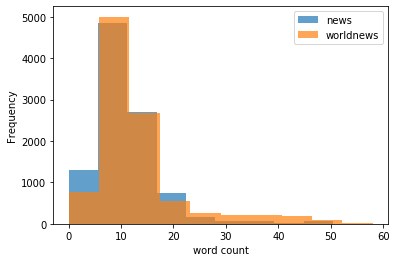

In [466]:
df[df['word_count'] <= 60].groupby('subreddit')['word_count'].plot(kind = 'hist', alpha = 0.7);
plt.legend(['news', 'worldnews']);
plt.xlabel('word count');
plt.savefig("./pics/word count_dist.png")

In [291]:
df.groupby('subreddit')['sentiment'].describe()

,count,mean,std,min,25%,50%,75%,max
subreddit,,,,,,,,
0,10000.0,-0.095207,0.424649,-0.9744,-0.4019,0.0,0.0,0.9750
1,10000.0,-0.133883,0.406799,-0.9790,-0.4767,0.0,0.0,0.9607


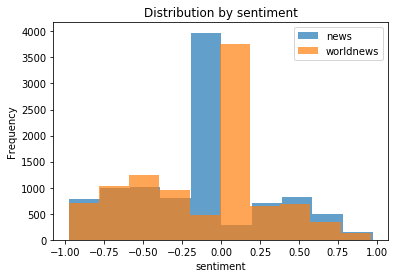

In [336]:
df.groupby('subreddit')['sentiment'].plot(kind = 'hist', alpha = 0.7);

plt.xlabel('sentiment');
plt.title('Distribution by sentiment');
plt.legend(['news', 'worldnews']);
plt.savefig("./assets/sentiment_dist.png")

___

Analyzing individual words by class after CountVectorizing..

In [293]:
cvec = CountVectorizer(stop_words='english', min_df=5, max_df=1.0)

cvec_subreddit_1 = cvec.fit_transform(df[df['subreddit'] == 1]['merged'])

top_words = pd.DataFrame(cvec_subreddit_1.toarray(),
                          columns=cvec.get_feature_names())

top_sorted = top_words.sum().sort_values(ascending = False)[:50]

top_sorted.sort_values(ascending = True, inplace = True)

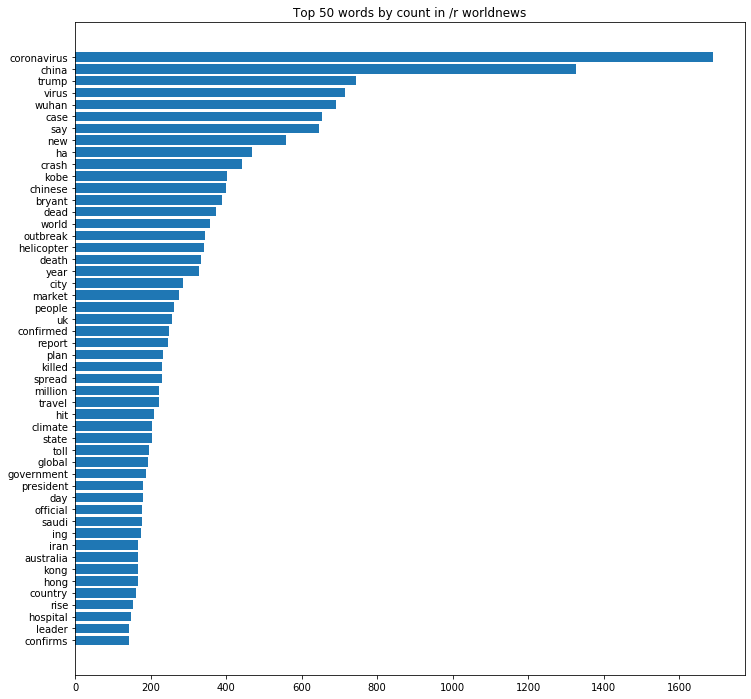

In [337]:
plt.figure(figsize=(12,12))
plt.barh(top_sorted.index,top_sorted.values);
plt.title('Top 50 words by count in /r worldnews');
plt.savefig("./assets/topwords1.png")

In [295]:
cvec_subreddit_2 = cvec.fit_transform(df[df['subreddit'] == 0]['merged'])

top_words2 = pd.DataFrame(cvec_subreddit_2.toarray(),
                          columns=cvec.get_feature_names())

top_sorted2 = top_words2.sum().sort_values(ascending = False)[:50]

top_sorted2.sort_values(ascending = True, inplace = True)

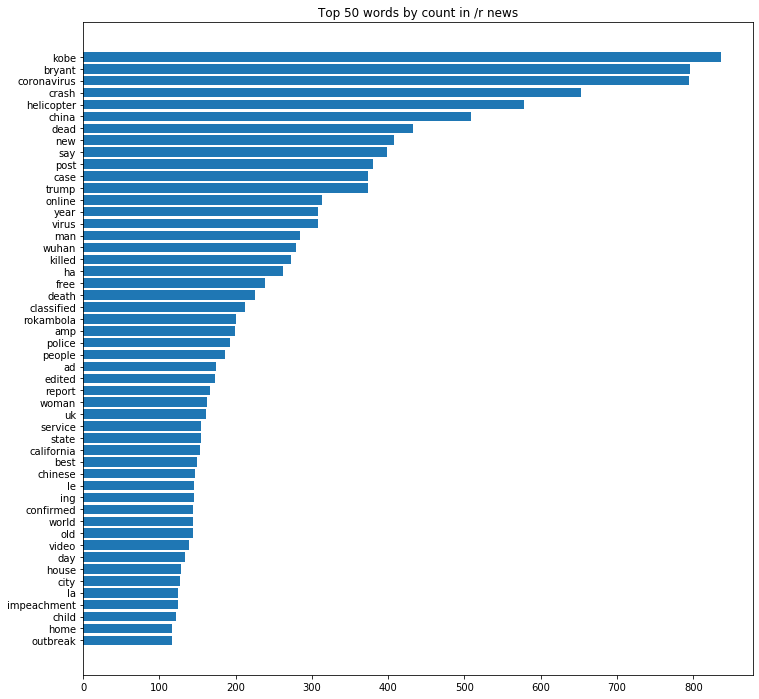

In [338]:
plt.figure(figsize=(12,12))
plt.barh(top_sorted2.index,top_sorted2.values);
plt.title('Top 50 words by count in /r news');
plt.savefig("./assets/topwords2.png")

Here I'm taking a look at overlapping words that showed up as top 50 words in both subreddits.

In [297]:
overlap= [n for n in top_sorted.index if n in top_sorted2.index]
overlap

['ing',
 'day',
 'state',
 'killed',
 'report',
 'confirmed',
 'uk',
 'people',
 'city',
 'year',
 'death',
 'helicopter',
 'outbreak',
 'world',
 'dead',
 'bryant',
 'chinese',
 'kobe',
 'crash',
 'ha',
 'new',
 'say',
 'case',
 'wuhan',
 'virus',
 'trump',
 'china',
 'coronavirus']

___

## Modeling

### Model_1 - Logisitic Regression with Count Vectorizer (text features only)

Defining x, y variabes and fitting the data to our model

In [300]:
X = df['merged']
y = df['subreddit']

In [301]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

Below we check the basline score to compare our model to. Our basline score is 0.5

In [302]:
y_test.value_counts(normalize = True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

Instantiating a pipeline and grid search paramters to iterate through

In [303]:
pipe = Pipeline([('cvec', CountVectorizer()), ('lr', LogisticRegression(solver='liblinear'))])

In [92]:
pipe_params = {
                'cvec__stop_words':[None, 'english'],
                'cvec__max_features':[1000,2000,3000,4000,5000], 
                'cvec__min_df':[2,3,4,5], 
                'cvec__max_df':[0.9, 0.95, 0.99], 
                'cvec__ngram_range':[(1,1), (1,2)]
}

In [93]:

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=5)

**Model_1 Evaluation:** . 

train acurracy = 0.696  
test accuracy = 0.7

In [94]:
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_estimator_)

0.6962
Pipeline(memory=None,
         steps=[('cvec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=0.9,
                                 max_features=4000, min_df=3,
                                 ngram_range=(1, 1), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=True, intercept_scaling=1,
                                    l1_ratio=None, max_iter=100,
                                    multi_class='warn', n_jobs=None,
               

In [102]:
model1 = gs.best_estimator_

In [103]:
model1.score(X_test, y_test)

0.7

### Model_2 - Logisitic Regression with Tfidf Vectorizer (text features only)

In [178]:
pipe = Pipeline([('tfid', TfidfVectorizer()), ('lr', LogisticRegression(solver='liblinear'))])

In [184]:
pipe_params = {
                'tfid__stop_words':[None, 'english'],
                'tfid__max_features':[1000,2000,3000,4000,5000], 
                'tfid__min_df':[2,3,4,5,10], 
                'tfid__max_df':[0.9, 0.95, 0.99], 
                'tfid__ngram_range':[(1,1), (1,2)]
}

In [180]:

gs = GridSearchCV(pipe,
                  pipe_params,
                  cv=5)

**Model_2 Evaluation:** . 

train acurracy = 0.71   
test accuracy = 0.7

In [185]:
gs.fit(X_train, y_train)
print(gs.best_score_)
print(gs.best_estimator_)

0.7114666666666667
Pipeline(memory=None,
         steps=[('tfid',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=0.9, max_features=10000,
                                 min_df=3, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, use_idf=True,
                                 vocabulary=None)),
                ('lr',
                 LogisticRegression(C=1.0, class_weight=None, dual=False,
                                    fit_intercept=

In [468]:
gs.score(X_test, y_test)

0.7088

___

### Model_3 - Logisitic Regression with Tfidf Vectorizer on text features, standard scaler on numeric features.

In [325]:
get_text_data = FunctionTransformer(lambda x: x['merged'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['word_count', 'sentiment']], validate = False)

In [459]:
X = df.drop('subreddit', axis = 1)
y = df['subreddit']

In [460]:
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    stratify=y,
                                                    random_state=42)

In [461]:
pipe_params = {
                 'features__text_features__tfid__stop_words':[None, 'english'],
                 'features__text_features__tfid__max_features':[1000,2000,3000,4000,5000], 
                 'features__text_features__tfid__min_df':[2,3,4,5,10], 
                 'features__text_features__tfid__max_df':[0.9, 0.95, 0.99], 
                 'features__text_features__tfid__ngram_range':[(1,1), (1,2)],
                'lr__penalty' : ['l1', 'l2']
}

In [462]:
pipe2 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tfid', TfidfVectorizer())
            ]))
    ])),
    ('lr', LogisticRegression())
])

In [463]:
import warnings
warnings.filterwarnings('ignore')

In [464]:
gs = GridSearchCV(pipe2, pipe_params, cv=5)
gs.fit(X_train, y_train)
gs.score(X_train, y_train)

0.7876

In [472]:
gs.best_estimator_.score(X_test, y_test)

0.7088

In [478]:
gs.best_params_

{'features__text_features__tfid__max_df': 0.9,
 'features__text_features__tfid__max_features': 5000,
 'features__text_features__tfid__min_df': 4,
 'features__text_features__tfid__ngram_range': (1, 2),
 'features__text_features__tfid__stop_words': 'english',
 'lr__penalty': 'l2'}

**Model_3 Evaluation:** . 

train acurracy = 0.79   
test accuracy = 0.71

### Further Evaluations
***Model 3 has been the highest performing model. Lets do further evaluation of that model to dive deeper.***

In [470]:
coefficients = gs.best_estimator_.named_steps['lr'].coef_[0]

In [469]:
#text features
text_features = gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['tfid'].get_feature_names()
numeric_features = ['word_count', 'sentiment_score']

features = numeric_features + text_features

Below is dataframe created to store our coefficent weights, and exponanted coefficients for interpreation

In [424]:
coef_df = pd.DataFrame({  
                        'features' : features, 
                        'coef' : coefficients,
                        'exp_coef': [np.exp(coef) for coef in coefficients]

})

coef_df.head()

#coef_df.sort_values('exp_coef', ascending = True)

,features,coef,exp_coef
0,word_count,0.249768,1.283728
1,sentiment_score,-0.096410,0.908092
2,abandon,0.029945,1.030397
3,abc,-0.143757,0.866098
4,abducted,0.263523,1.301507


Looking at the top 20 coefficients affecting our model.  

e.g. the for each occurance of the word 'climate', our subreddit is 15.5 times more likely to be from world news!

In [425]:
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(20)


,features,coef,exp_coef
813,climate,2.743305,15.538247
713,china,2.394255,10.960027
2275,japan,2.380665,10.812088
4521,totestravel,2.359633,10.587065
1785,germany,2.257782,9.561857
2246,israeli,2.181294,8.857760
3828,saudi,2.180146,8.847602
1071,dai,2.178254,8.830873
4724,usa,2.152831,8.609192
472,brazil,2.087974,8.068550


***Our Model has a lot of features. Organizing visualizations to determine the most impactful coefficients and features***

In [426]:
coef_df = coef_df.set_index('features')

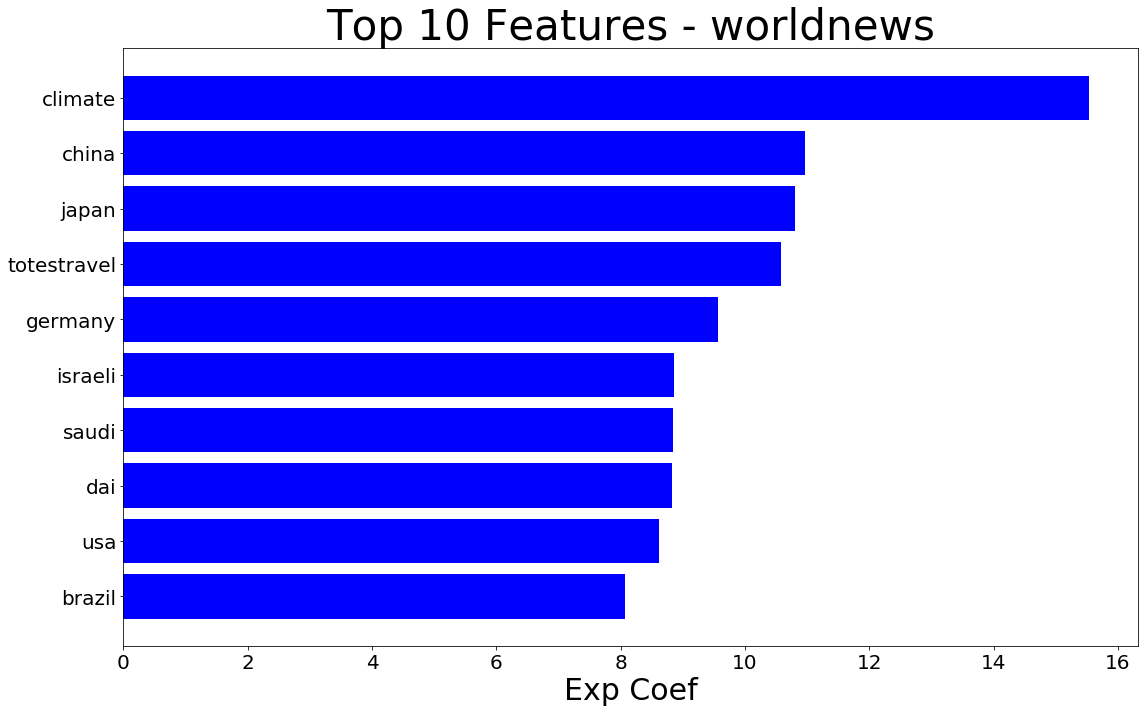

In [437]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(16,10))
plt.barh(labels, weights, color = 'blue')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - worldnews', fontsize=42)
plt.tight_layout()
plt.savefig("./pics/top_features1.png")

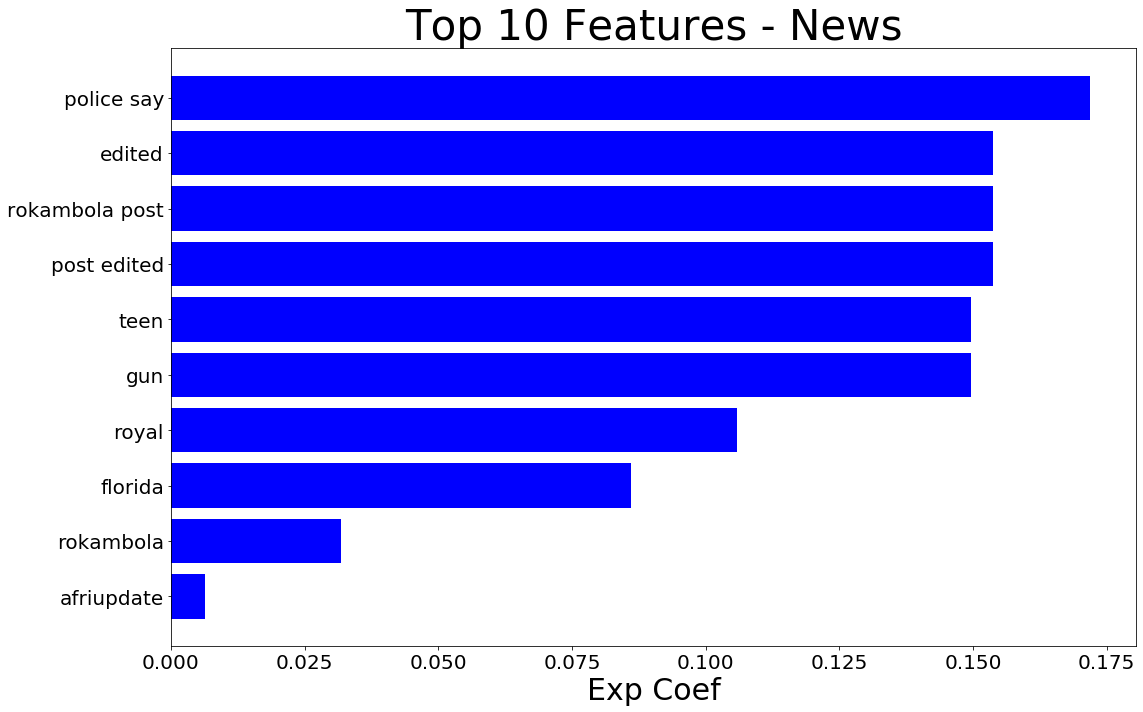

In [475]:
weights = coef_df['exp_coef'].tail(10).sort_values()
labels = weights.index

plt.figure(figsize=(16,10))
plt.barh(labels, weights, color = 'blue')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - News', fontsize=42)
plt.tight_layout()
plt.savefig("./pics/top_features2.png")

In [458]:
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    #print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

**Visualizing a confusion matrix to see our predictions results vs actual results**

In [434]:
# build a function to print out a nice confusion matrix
preds = gs.best_estimator_.predict(X_test)

nice_conmat(y_test, preds, ['news', 'world_news'])

,Predicted news,Predicted world_news
Actual news,1783,717
Actual world_news,739,1761


___

### Model_4 RandomForest with Tfidf Vectorizer on text features and standard scaler on numeric features

In [453]:
pipe_params2 = {
                'features__text_features__tfid__stop_words':['english'],
                'features__text_features__tfid__max_features':[10000], 
                'features__text_features__tfid__min_df':[5], 
                'features__text_features__tfid__max_df':[0.90], 
                'features__text_features__tfid__ngram_range':[(1,1), (1,2)],
                'rf__n_estimators':[125],
                'rf__max_depth': [4, 6],
                'rf__max_features': ['auto']
    
}

In [454]:
pipe3 = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('tfid', TfidfVectorizer())
            ]))
    ])),
    ('rf', RandomForestClassifier())
])

In [456]:
gs2 = GridSearchCV(pipe3, pipe_params2, cv=5)
gs2.fit(X_train, y_train)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('features',
                                        FeatureUnion(n_jobs=None,
                                                     transformer_list=[('numeric_features',
                                                                        Pipeline(memory=None,
                                                                                 steps=[('selector',
                                                                                         FunctionTransformer(accept_sparse=False,
                                                                                                             check_inverse=True,
                                                                                                             func=<function <lambda> at 0x1a731f1c20>,
                                                                                        

**Model_4 Evaluation:** . 

train acurracy = 0.67   
test accuracy = 0.66

In [457]:
print(gs2.score(X_train, y_train))
print(gs2.best_estimator_)

0.6726
Pipeline(memory=None,
         steps=[('features',
                 FeatureUnion(n_jobs=None,
                              transformer_list=[('numeric_features',
                                                 Pipeline(memory=None,
                                                          steps=[('selector',
                                                                  FunctionTransformer(accept_sparse=False,
                                                                                      check_inverse=True,
                                                                                      func=<function <lambda> at 0x1a731f1c20>,
                                                                                      inv_kw_args=None,
                                                                                      inverse_func=None,
                                                                                      kw_args=None,
                               

In [473]:
gs2.score(X_test, y_test)

0.6618